In [299]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [300]:
df = pd.read_csv("MagicBricks.csv")

In [301]:
df.head()

,Area,BHK,Bathroom,Furnishing,Locality,Parking,Price,Status,Transaction,Type,Per_Sqft
0,800.0,3,2.0,Semi-Furnished,Rohini Sector 25,1.0,6500000,Ready_to_move,New_Property,Builder_Floor,NaN
1,750.0,2,2.0,Semi-Furnished,"J R Designers Floors, Rohini Sector 24",1.0,5000000,Ready_to_move,New_Property,Apartment,6667.0
2,950.0,2,2.0,Furnished,"Citizen Apartment, Rohini Sector 13",1.0,15500000,Ready_to_move,Resale,Apartment,6667.0
3,600.0,2,2.0,Semi-Furnished,Rohini Sector 24,1.0,4200000,Ready_to_move,Resale,Builder_Floor,6667.0
4,650.0,2,2.0,Semi-Furnished,Rohini Sector 24 carpet area 650 sqft status R...,1.0,6200000,Ready_to_move,New_Property,Builder_Floor,6667.0


In [302]:
df1 = df.drop(["Parking", "Furnishing", "Type"], axis="columns")
df2 = df1.dropna()
df2.head()

,Area,BHK,Bathroom,Locality,Price,Status,Transaction,Per_Sqft
1,750.0,2,2.0,"J R Designers Floors, Rohini Sector 24",5000000,Ready_to_move,New_Property,6667.0
2,950.0,2,2.0,"Citizen Apartment, Rohini Sector 13",15500000,Ready_to_move,Resale,6667.0
3,600.0,2,2.0,Rohini Sector 24,4200000,Ready_to_move,Resale,6667.0
4,650.0,2,2.0,Rohini Sector 24 carpet area 650 sqft status R...,6200000,Ready_to_move,New_Property,6667.0
5,1300.0,4,3.0,Rohini Sector 24,15500000,Ready_to_move,New_Property,6667.0


In [303]:
# Detect and remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Removing outliers for 'Area' and 'Price'
df_cleaned = remove_outliers(df2, 'Area')
df_cleaned = remove_outliers(df_cleaned, 'Price')

# Adding a new feature - Price per Square Foot
df_cleaned['Price_per_Sqft'] = df_cleaned['Price'] / df_cleaned['Area']

# Check the cleaned data
df_cleaned.describe()


,Area,BHK,Bathroom,Price,Per_Sqft,Price_per_Sqft
count,901.000000,901.000000,901.000000,9.010000e+02,901.000000,901.000000
mean,1136.082936,2.634850,2.342952,1.472841e+07,13811.629301,14045.994523
std,586.662491,0.874875,0.887586,1.228396e+07,17410.236897,23452.406271
min,28.000000,1.000000,1.000000,1.000000e+06,1667.000000,481.363367
25%,720.000000,2.000000,2.000000,4.620000e+06,6111.000000,6347.826087
50%,1044.098300,3.000000,2.000000,1.150000e+07,10000.000000,10493.827160
75%,1500.000000,3.000000,3.000000,2.200000e+07,15556.000000,16283.524904
max,2970.000000,7.000000,6.000000,5.250000e+07,183333.000000,538461.538462


In [304]:
df_cleaned=df_cleaned.drop(["Status","Transaction"], axis = "columns")
df_cleaned.head(1)

,Area,BHK,Bathroom,Locality,Price,Per_Sqft,Price_per_Sqft
1,750.0,2,2.0,"J R Designers Floors, Rohini Sector 24",5000000,6667.0,6666.666667


In [318]:
from sklearn.ensemble import RandomForestRegressor# One-Hot Encoding for Locality
dummies = pd.get_dummies(df_cleaned.Locality)
df_final = pd.concat([df_cleaned, dummies], axis="columns").drop("Locality", axis="columns")

# Features and Target
X = df_final.drop("Price", axis="columns")
y = df_final["Price"]

# Train-Test Split (No Scaling Needed for Random Forest)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

# Train the Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the Model
score = rf_model.score(X_test, y_test)
print(f"Model Score: {score}")


Model Score: 0.9511943850949546


In [314]:
import json
columns = list(X.columns)
with open('./columns.json', 'w') as f:
    json.dump({"data_columns": columns}, f)


In [315]:
import pickle

# Path to save the model
model_path = './final_random_forest_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(rf_model, f)

print(f"Model saved at: {model_path}")


Model saved at: ./final_random_forest_model.pkl


In [319]:
import numpy as np
import pickle
import json

# Load the model and column names
with open('./final_random_forest_model.pkl', 'rb') as f:
    model = pickle.load(f)
with open('./columns.json', 'r') as f:
    data_columns = json.load(f)['data_columns']

def predict_price(location, area, bhk, bath):
    try:
        # Ensure location exists in columns
        loc_index = data_columns.index(location.lower()) if location.lower() in data_columns else -1

        # Create input array with correct feature order
        x = np.zeros(len(data_columns))
        x[0] = area
        x[1] = bhk
        x[2] = bath
        if loc_index >= 0:
            x[loc_index] = 1

        # Predict using the model
        predicted_price = model.predict([x])[0]
        return round(predicted_price, 2)
    except Exception as e:
        return str(e)

print(predict_price('Kalkaji Extension', 500, 1, 1))


1674000.0


C:\Users\ahmed\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [320]:
y_pred = model.predict(X_test)
score = r2_score(y_test, y_pred)
print(f"Test Score: {score}")


Test Score: 0.9504743046680735


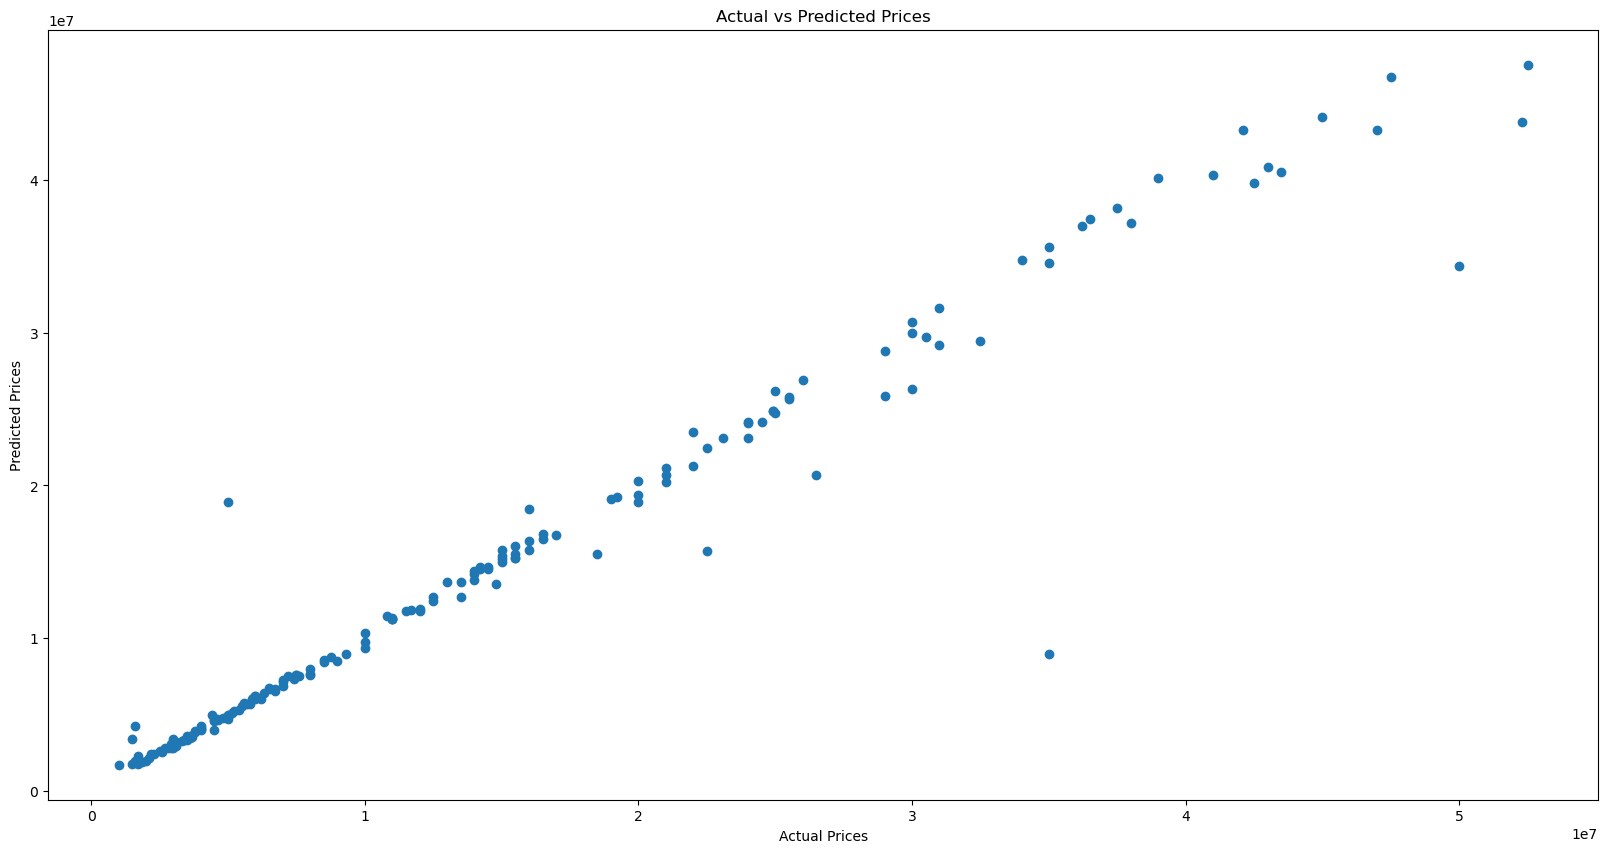

In [321]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()
